In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')
os.listdir()

!pip install opencv-python
!pip install matplotlib


In [3]:
TRAIN_PATH = "kaggle/input/captcha-hacker-2023-spring/dataset/train"
TEST_PATH = "kaggle/input/captcha-hacker-2023-spring/dataset/test"
OUTPUT_PATH = "kaggle/output"
PRETRAINED_WEIGHT_PATH = "Colab Notebooks/Pre-trained weight"


device = "cuda"
Enable_Line_Graph = True

In [4]:
import numpy as np
import csv
import cv2
import random
import copy
import os
import matplotlib
from matplotlib import pyplot as plt
import gc

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("Done!")

Done!


In [5]:
#Check version
print("cv2 version= ", cv2.__version__)
print("matplotlib version= ", matplotlib.__version__)
print("torch version= ", torch.__version__)

cv2 version=  4.7.0
matplotlib version=  3.7.1
torch version=  2.0.1+cu118


In [6]:
alphabets = "_abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
alphabets2index = {alphabet:i for i, alphabet in enumerate(alphabets)}


resize_Task1 = 96
resize_Task2 = 96
resize_Task3 = 96
channel = 1

In [7]:
def random_rotation(image, degrees):
    angle = np.random.uniform(-degrees, degrees)
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [8]:
class Task_Dataset(Dataset):
    def __init__(self, data, root, class_name, resize, return_filename=False, augmentations=False):
        self.data = None
        if class_name is None:
            self.data = [sample for sample in data]
        else:
            self.data = [sample for sample in data if sample[0].startswith(class_name)]
        self.return_filename = return_filename
        self.root = root
        self.resize = resize
        self.class_name = class_name
        self.augmentations = augmentations
    
    def __getitem__(self, index):
        filename, label = self.data[index]
        img = cv2.imread(f"{self.root}/{filename}")
        
        if self.class_name == 'task1':
            img = cv2.resize(img, (self.resize, self.resize))
        elif self.class_name == 'task2':
            img = cv2.resize(img, (self.resize, self.resize))
        elif self.class_name == 'task3':
            img = cv2.resize(img, (self.resize, self.resize))
        
        if self.augmentations:
            img = random_rotation(img, degrees=30)
        
        if channel == 1:
            img = np.mean(img, axis=2)
            img = np.expand_dims(img, axis=-1)
        if channel == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.return_filename:
            return torch.FloatTensor((img - 128) / 128), filename
        else:
            if len(label) == 1:
                return torch.FloatTensor((img - 128) / 128), alphabets2index[label]
            else:
                label_list = [alphabets2index[c] for c in label]
                label_list = torch.IntTensor(label_list)
                return torch.FloatTensor((img - 128) / 128), label_list

    def __len__(self):
        return len(self.data)


In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, train_threshold=1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter_1 = 0
        self.counter_2 = 0
        self.min_validation_loss = np.inf
        self.max_validation_loss = 0
        self.last_validation_loss = 0
        self.last_training_loss = 0
        self.train_threshold = train_threshold

    def early_stop(self, validation_loss, training_loss):
        if validation_loss <= 0 or training_loss > self.train_threshold:
            return False
        
        if validation_loss > self.max_validation_loss:
            self.max_validation_loss = validation_loss
            self.counter_2 = 0
        elif (self.max_validation_loss - self.min_validation_loss) > 1:
            self.counter_2 += 1
            if self.counter_2 >= self.patience:
                return True
            
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter_1 = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter_1 += 1
            if self.counter_1 >= self.patience:
                return True
            
        return False

In [10]:
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="train_losses")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="val_losses")
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplots_adjust(wspace=0.3)
    plt.show()

    if train_accuracies is not None and val_accuracies is not None:
        plt.plot(train_accuracies, label="train_acc")
        plt.plot(val_accuracies, label="val_acc")
        plt.ylim([0, 1.1])
        plt.xlabel('Epoch')
        plt.ylabel('Training Accuracy')
        plt.title('Training Accuracy over Epochs')
        plt.legend()

        plt.subplots_adjust(wspace=0.3)
        plt.show()

# **Task 1 model (CNN)**

In [11]:
class Model_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channel, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fl_layers = nn.Sequential(nn.Flatten())
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear((512), 256),
            nn.Dropout(0.3),
            nn.Linear(256, len(alphabets))
        )
        
    def forward(self, x):
        batch_size, height, width, channels = x.shape
        x = x.view(batch_size, channels, height, width)
        x = self.conv_layers(x)
        x = self.fl_layers(x)
        x = self.fc_layers(x)
        return x

# **Task 2 & Task 3 model (CRNN)**

In [12]:
class Model_CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channel, 256, 9, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, 3),
            nn.Conv2d(256, 256, (4, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        # RNN
        self.rnn1 = nn.GRU(input_size=256, 
                            hidden_size=1024,
                            bidirectional=True
                          )
        self.linear1 = nn.Linear(7424, 256)
        self.linear2 = nn.Linear(1024 * 2, len(alphabets) + 1)
        
    def forward(self, x):
        batch_size, height, width, channels = x.shape
        x = x.view(batch_size, channels, height, width)
        x = self.conv_layers(x)
        
        batch_size, channels, width, height = x.shape
        x = x.view(batch_size, -1, height)
        x = x.permute(0, 2, 1)
        x = self.linear1(x)
        x = x.permute(1, 0, 2)
        
        x, _ = self.rnn1(x)
        output = self.linear2(x)
        return output

# **Data Pre-processing**

train_data[0]: ['filename', 'label']
train_ds_Task1[0].shape:  torch.Size([96, 96, 1]) 33


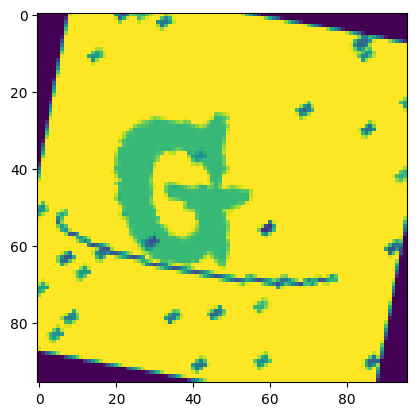

train_ds_Task2[0].shape:  torch.Size([96, 96, 1]) tensor([47, 49], dtype=torch.int32)


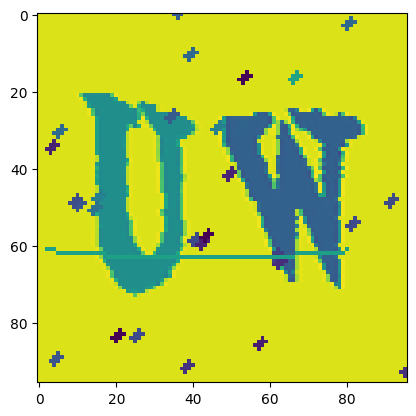

train_ds_Task3[0].shape:  torch.Size([96, 96, 1]) tensor([ 9,  6,  5, 11], dtype=torch.int32)


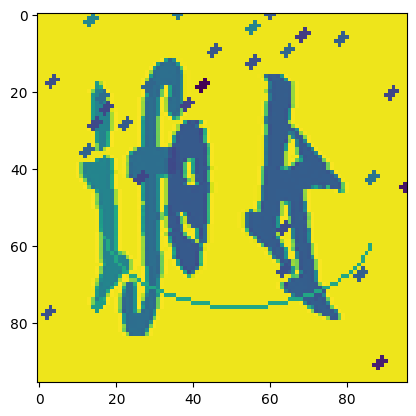

In [13]:
train_data = []
val_data = []

with open(f'{TRAIN_PATH}/annotations.csv', newline='') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        if random.random() < 0.8:
            train_data.append(row)
        else:
            val_data.append(row)

print("train_data[0]:", train_data[0])


#Task 1
train_ds_Task1 = Task_Dataset(train_data, root=TRAIN_PATH, class_name = "task1", resize = resize_Task1
                              , augmentations=True)
train_dl_Task1 = DataLoader(train_ds_Task1, batch_size=100, num_workers=0, drop_last=True, shuffle=True)

img , l = train_ds_Task1[0]
print("train_ds_Task1[0].shape: ",img.shape, l)
plt.imshow(img)
plt.show()

val_ds_Task1 = Task_Dataset(val_data, root=TRAIN_PATH, class_name = "task1", resize = resize_Task1)
val_dl_Task1 = DataLoader(val_ds_Task1, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

#Task 2
train_ds_Task2 = Task_Dataset(train_data, root=TRAIN_PATH, class_name = "task2", resize = resize_Task2
                              , augmentations=False)
train_dl_Task2 = DataLoader(train_ds_Task2, batch_size=100, num_workers=0, drop_last=True, shuffle=True)

img , l = train_ds_Task2[0]
print("train_ds_Task2[0].shape: ",img.shape, l)
plt.imshow(img)
plt.show()

val_ds_Task2 = Task_Dataset(val_data, root=TRAIN_PATH, class_name = "task2", resize = resize_Task2)
val_dl_Task2 = DataLoader(val_ds_Task2, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

#Task 3
train_ds_Task3 = Task_Dataset(train_data, root=TRAIN_PATH, class_name = "task3", resize = resize_Task3
                              , augmentations=False)
train_dl_Task3 = DataLoader(train_ds_Task3, batch_size=100, num_workers=0, drop_last=True, shuffle=True)

img , l = train_ds_Task3[0]
print("train_ds_Task3[0].shape: ",img.shape, l)
plt.imshow(img)
plt.show()

val_ds_Task3 = Task_Dataset(val_data, root=TRAIN_PATH, class_name = "task3", resize = resize_Task3)
val_dl_Task3= DataLoader(val_ds_Task3, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

# **Task 1**

In [14]:
model_Task1 = Model_CNN().to(device)
optimizer = torch.optim.Adam(model_Task1.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=5, min_delta=0.5)
loss_fn = nn.CrossEntropyLoss()
epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_label = []
val_label = []
train_pred = []
val_pred = []

best_model_wts_Task1 = copy.deepcopy(model_Task1.state_dict())
best_acc_Task1 = 0.0

train_epoch_loss = 0.0

for epoch in range(epochs):
    print(f"Epoch [{epoch}]")
    model_Task1.train()
    epoch_loss = 0.0 
    
    #training
    sample_count_t = 0
    correct_count_t = 0
    for image, label in train_dl_Task1:
        image = image.to(device)
        label = label.to(device)
        
        pred = model_Task1(image)
        pred = pred.to('cpu')
        label = label.to('cpu')
        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        pred = torch.argmax(pred, dim=1)
        sample_count_t += len(image)
        correct_count_t += (label == pred).sum()
        
        if epoch == epochs - 1:
            label = label.tolist()
            pred = pred.tolist()
            train_label.extend(np.transpose(label))
            train_pred.extend(np.transpose(pred))
    
    epoch_loss /= len(train_dl_Task1)
    train_losses.append(epoch_loss)
    train_accuracy = correct_count_t / sample_count_t
    train_accuracies.append(train_accuracy)
    train_epoch_loss = epoch_loss
    print("Epoch_loss:", epoch_loss)
    print("Task 1 accuracy (training):", train_accuracy.item())
    
    #validation
    sample_count = 0
    correct_count = 0
    model_Task1.eval()
    with torch.no_grad():
        for image, label in val_dl_Task1:
            image = image.to(device)
            label = label.to(device)

            image_size = image.size(0)

            if image_size < val_dl_Task1.batch_size:
                tensor = torch.ones((val_dl_Task1.batch_size - image_size), resize_Task1, resize_Task1, channel)
                tensor = tensor.to(device)
                image = torch.cat((image, tensor),0)

            pred = model_Task1(image)
            pred = pred[0:image_size]
            pred = pred.to('cpu')
            label = label.to('cpu')
            loss = loss_fn(pred, label)
            epoch_loss += loss.item()

            pred = torch.argmax(pred, dim=1)

            sample_count += len(image)
            correct_count += (label == pred).sum()

            if epoch == epochs - 1:
                label = label.tolist()
                pred = pred.tolist()
                val_label.extend(np.transpose(label))
                val_pred.extend(np.transpose(pred))
    
    epoch_loss /= len(val_dl_Task1)
    val_losses.append(epoch_loss)
    
    val_accuracy = correct_count / sample_count
    val_accuracies.append(val_accuracy)
    print("Epoch_loss:", epoch_loss)
    print("Task 1 accuracy (validation):", val_accuracy.item())
    
    #Best model
    #if val_accuracy > best_acc_Task1:
    #    best_acc_Task1 = val_accuracy
    #    best_model_wts_Task1 = copy.deepcopy(model_Task1.state_dict())
    
    #Early stopping
    #if early_stopper.early_stop(epoch_loss, train_epoch_loss): 
    #    print("Early stopping!")
    #    break
        
print("Done!")

Epoch [0]
Epoch_loss: 4.344271242618561
Task 1 accuracy (training): 0.026249999180436134
Epoch_loss: 5.479454055428505
Task 1 accuracy (validation): 0.014999999664723873
Epoch [1]
Epoch_loss: 3.994927391409874
Task 1 accuracy (training): 0.03812500089406967
Epoch_loss: 6.943603273481131
Task 1 accuracy (validation): 0.014999999664723873
Epoch [2]
Epoch_loss: 3.681649789214134
Task 1 accuracy (training): 0.08124999701976776
Epoch_loss: 5.245966341346502
Task 1 accuracy (validation): 0.054999999701976776
Epoch [3]
Epoch_loss: 3.314339354634285
Task 1 accuracy (training): 0.13750000298023224
Epoch_loss: 4.560354221612215
Task 1 accuracy (validation): 0.08749999850988388
Epoch [4]
Epoch_loss: 2.9183429926633835
Task 1 accuracy (training): 0.20624999701976776
Epoch_loss: 3.9058824591338634
Task 1 accuracy (validation): 0.13750000298023224
Epoch [5]
Epoch_loss: 2.4582179486751556
Task 1 accuracy (training): 0.3018749952316284
Epoch_loss: 3.2668888196349144
Task 1 accuracy (validation): 0.245

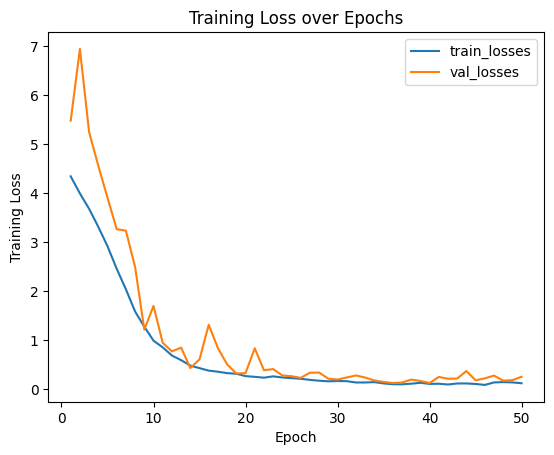

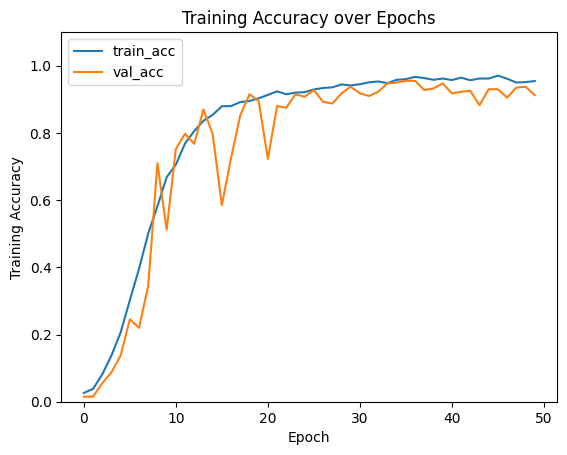

In [15]:
if Enable_Line_Graph:
    train_accuracies = torch.tensor(train_accuracies, device='cpu')
    val_accuracies = torch.tensor(val_accuracies, device='cpu')
    plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
def calculat_acc(output, target, num_char):
    output = output.to('cpu')
    target = target.to('cpu')
    answer = []
    for case in target:
        target_text = ''
        for t in case:
            target_text += alphabets[t]
        answer.append(target_text)
    
    output = output.permute(1, 0, 2)
    output = output.log_softmax(2)
    output = output.argmax(2)
    output = output.cpu().detach().numpy()
    
    correct_list = []
    pred_text = []
    for batch in output:
        pred = ''
        then = 0
        for x in batch:
            if then != x:
                if x > 0 and x < len(alphabets):
                    pred += alphabets[x]
            then = x
        pred_text.append(pred)
        
    for i, j in zip(answer, pred_text):
        if i == j:
            correct_list.append(1)
        else:
            correct_list.append(0)
    
    if len(correct_list) == 0:
        return 0
    else:
        acc = sum(correct_list) / len(correct_list)
    return acc

In [17]:
loss_fn = nn.CTCLoss()
def compute_loss(output, target, num_char):
    output = output.to('cpu')
    target = target.to('cpu')
    
    T = output.size(0)
    N = output.size(1)
    
    output_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.int32)
    target_lengths = torch.full(size=(N,), fill_value=num_char, dtype=torch.int32)
    
    loss = loss_fn(output, target, output_lengths, target_lengths)
    return loss

In [18]:
def model_fit(Task, model, epochs, optimizer, lr_scheduler, early_stopper
             ,train_losses, val_losses, train_accuracies, val_accuracies
             , best_model_wts, best_acc):
    train_dl = None
    val_dl = None
    resize = None
    num_captcha = 0
    epcho_threshold = 0
    train_epoch_loss = 0
    
    if Task == "task1":
        train_dl = train_dl_Task1
        val_dl = val_dl_Task1
        resize = resize_Task1
        num_captcha = 1
        epcho_threshold = 40
    
    if Task == "task2":
        train_dl = train_dl_Task2
        val_dl = val_dl_Task2
        resize = resize_Task2
        num_captcha = 2
        epcho_threshold = 40
        
    if Task == "task3":
        train_dl = train_dl_Task3
        val_dl = val_dl_Task3
        resize = resize_Task3
        num_captcha = 4
        epcho_threshold = 25

    train_label = torch.IntTensor([]).to('cpu')
    val_label = torch.IntTensor([]).to('cpu')
    train_pred = torch.IntTensor([]).to('cpu')
    val_pred = torch.IntTensor([]).to('cpu')

    for epoch in range(epochs):
        print(f"Epoch [{epoch}]")
        model.train()
        epoch_loss = 0.0

        #training
        for image, label in train_dl:
            image = image.to(device)
            label = label.to(device)

            pred = model(image)
            loss =  compute_loss(pred, label, num_captcha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            train_pred = torch.cat((train_pred, pred.to('cpu')), dim=1)
            train_label = torch.cat((train_label, label.to('cpu')), dim=0)

        epoch_loss /= len(train_dl)
        train_losses.append(epoch_loss)
        train_accuracy = calculat_acc(train_pred, train_label, num_captcha)
        train_accuracies.append(train_accuracy)
        train_epoch_loss = epoch_loss
        print("Epoch_loss:", epoch_loss)
        print("Accuracy (training):", train_accuracy)

        #validation
        model.eval()
        with torch.no_grad():
            for image, label in val_dl:
                image = image.to(device)
                label = label.to(device)

                image_size = image.size(0)
                if image_size < val_dl.batch_size:
                    tensor = torch.ones((val_dl.batch_size - image_size), resize, resize, channel)
                    tensor = tensor.to(device)
                    image = torch.cat((image, tensor),0)

                pred= model(image)
                pred = pred[: , :image_size, :]
                loss = compute_loss(pred, label, num_captcha)

                epoch_loss += loss.item()

                val_pred = torch.cat((val_pred, pred.to('cpu')), dim=1)
                val_label = torch.cat((val_label, label.to('cpu')), dim=0)

        epoch_loss /= len(val_dl)
        val_losses.append(epoch_loss)
        val_accuracy = calculat_acc(val_pred, val_label, num_captcha)
        val_accuracies.append(val_accuracy)
        print("Epoch_loss:", epoch_loss)
        print("Accuracy (validation):", val_accuracy)
        

        # Best model
        #if val_accuracy > best_acc:
        #    best_acc = val_accuracy
        #    best_model_wts = copy.deepcopy(model.state_dict())
        
        if lr_scheduler is not None:
            lr_scheduler.step(epoch_loss)
        if epoch > epcho_threshold:
            #Early stopping
            if early_stopper.early_stop(epoch_loss, train_epoch_loss): 
                print("Early stopping!")
                break

    print("Done!")
    '''
    if Task == "task1":
        torch.save(model.state_dict(), 'model_Task1.pt')
    
    if Task == "task2":
        torch.save(model.state_dict(), 'model_Task2.pt')
        
    if Task == "task3":
        torch.save(model.state_dict(), 'model_Task3.pt')
    '''

# **Task 2**

In [19]:
model_Task2 = Model_CRNN().to(device)
model_Task2.load_state_dict(torch.load(f'{PRETRAINED_WEIGHT_PATH}/model_Task3.pt'))
optimizer = torch.optim.Adam(model_Task2.parameters(), lr=1e-4)
lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, verbose=True, patience=5)
early_stopper = EarlyStopper(patience=8, min_delta=0.7, train_threshold=1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Best model
best_model_wts_Task2 = copy.deepcopy(model_Task2.state_dict())
best_acc_Task2 = 0.0

model_fit("task2", model_Task2, 20, optimizer, lr_scheduler, early_stopper
         ,train_losses, val_losses, train_accuracies, val_accuracies
         , best_model_wts_Task2, best_acc_Task2)

Epoch [0]
Epoch_loss: 1.2531588488724084
Accuracy (training): 0.4785
Epoch_loss: 1.5848165355902164
Accuracy (validation): 0.6285714285714286
Epoch [1]
Epoch_loss: 0.6567390859127045
Accuracy (training): 0.60175
Epoch_loss: 0.7373483359813691
Accuracy (validation): 0.676530612244898
Epoch [2]
Epoch_loss: 0.4910241737961769
Accuracy (training): 0.6711666666666667
Epoch_loss: 0.699503107368946
Accuracy (validation): 0.7081632653061225
Epoch [3]
Epoch_loss: 0.3790815733373165
Accuracy (training): 0.718
Epoch_loss: 0.6372287981212139
Accuracy (validation): 0.725
Epoch [4]
Epoch_loss: 0.3198602467775345
Accuracy (training): 0.7549
Epoch_loss: 0.6401428872346878
Accuracy (validation): 0.7448979591836735
Epoch [5]
Epoch_loss: 0.27475754991173745
Accuracy (training): 0.7844166666666667
Epoch_loss: 0.6292364926636219
Accuracy (validation): 0.758843537414966
Epoch [6]
Epoch_loss: 0.21793295592069625
Accuracy (training): 0.8083571428571429
Epoch_loss: 0.7340759548544884
Accuracy (validation): 0.7

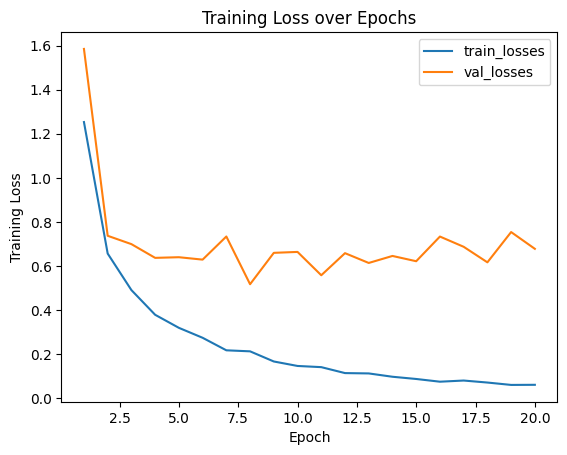

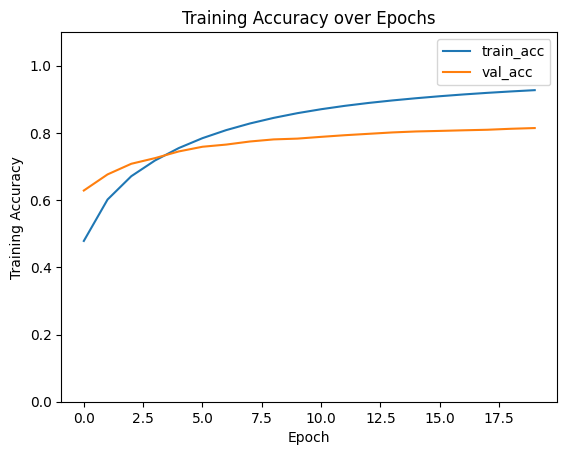

In [20]:
if Enable_Line_Graph:
    train_accuracies = torch.tensor(train_accuracies, device='cpu')
    val_accuracies = torch.tensor(val_accuracies, device='cpu')
    plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

# **Task 3**

In [21]:
model_Task3 = Model_CRNN().to(device)
model_Task3.load_state_dict(torch.load(f'{PRETRAINED_WEIGHT_PATH}/model_Task2.pt'))
optimizer = torch.optim.Adam(model_Task3.parameters(), lr=1e-4)
lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, verbose=True, patience=5)
early_stopper = EarlyStopper(patience=8, min_delta=0.7, train_threshold=1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Best model
best_model_wts_Task3 = copy.deepcopy(model_Task3.state_dict())
best_acc_Task3 = 0.0

model_fit("task3", model_Task3, 50, optimizer, lr_scheduler, early_stopper
         ,train_losses, val_losses, train_accuracies, val_accuracies
         , best_model_wts_Task3, best_acc_Task3)

Epoch [0]
Epoch_loss: 1.5014996100217104
Accuracy (training): 0.225625
Epoch_loss: 1.1554550400469452
Accuracy (validation): 0.3667953667953668
Epoch [1]
Epoch_loss: 0.8529488127678633
Accuracy (training): 0.32765625
Epoch_loss: 0.9020251443143934
Accuracy (validation): 0.4137709137709138
Epoch [2]
Epoch_loss: 0.7051838599145412
Accuracy (training): 0.3934375
Epoch_loss: 0.811743266414851
Accuracy (validation): 0.4598884598884599
Epoch [3]
Epoch_loss: 0.6006188178434968
Accuracy (training): 0.44859375
Epoch_loss: 0.6959919343935326
Accuracy (validation): 0.49388674388674386
Epoch [4]
Epoch_loss: 0.5293657667934895
Accuracy (training): 0.4930625
Epoch_loss: 0.6309907981194556
Accuracy (validation): 0.5163449163449163
Epoch [5]
Epoch_loss: 0.465544443577528
Accuracy (training): 0.53109375
Epoch_loss: 0.6182064539752901
Accuracy (validation): 0.5362505362505362
Epoch [6]
Epoch_loss: 0.4153968822211027
Accuracy (training): 0.5647767857142857
Epoch_loss: 0.6713515461888164
Accuracy (validat

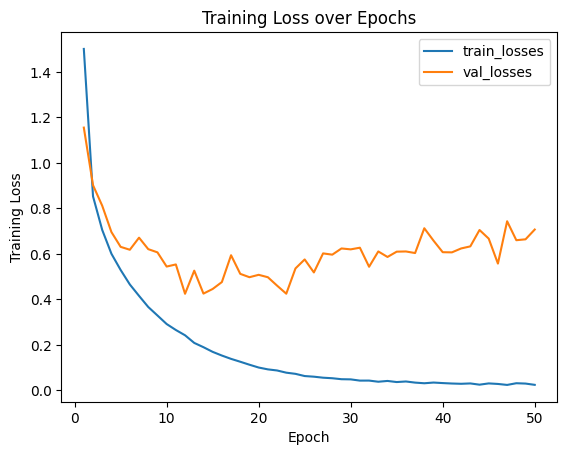

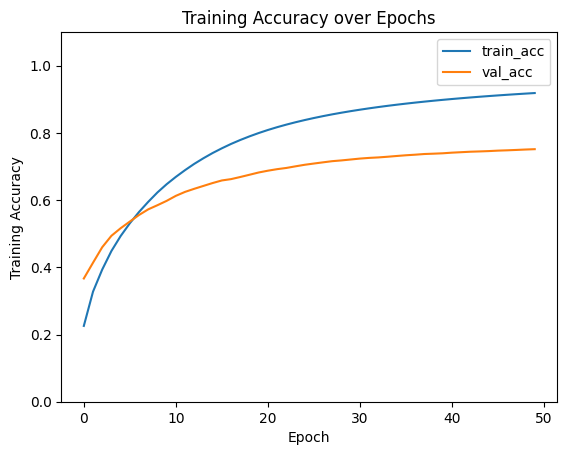

In [22]:
if Enable_Line_Graph:
    train_accuracies = torch.tensor(train_accuracies, device='cpu')
    val_accuracies = torch.tensor(val_accuracies, device='cpu')
    plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies)

# **Pred**

In [23]:
test_data = []
with open(f'{TEST_PATH}/../sample_submission.csv', newline='') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        test_data.append(row)

print("test_data.shape: ", np.array(test_data).shape)

test_data.shape:  (10001, 2)


In [24]:
test_ds_Task1 = Task_Dataset(test_data, root=TEST_PATH, class_name = "task1", resize = resize_Task1, return_filename=True)
test_dl_Task1 = DataLoader(test_ds_Task1, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

test_ds_Task2 = Task_Dataset(test_data, root=TEST_PATH, class_name = "task2", resize = resize_Task2, return_filename=True)
test_dl_Task2 = DataLoader(test_ds_Task2, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

test_ds_Task3 = Task_Dataset(test_data, root=TEST_PATH, class_name = "task3", resize = resize_Task3, return_filename=True)
test_dl_Task3 = DataLoader(test_ds_Task3, batch_size=100, num_workers=0, drop_last=False, shuffle=False)

In [25]:
output_filename = f'{OUTPUT_PATH}/submission.csv'
if os.path.exists(output_filename):
    os.remove(output_filename)
csv_writer_submit = csv.writer(open(output_filename, 'w', newline=''))
csv_writer_submit.writerow(["filename", "label"])

16

## **Task 1 pred**

In [26]:
counter_1 = 0

model_Task1.eval()
for image, filenames in test_dl_Task1:
    image = image.to(device)
    
    image_size = image.size(0)
    if image_size < test_dl_Task1.batch_size:
        tensor = torch.ones((test_dl_Task1.batch_size - image_size), resize_Task1, resize_Task1, channel)
        tensor = tensor.to(device)
        image = torch.cat((image, tensor),0)
    
    pred = model_Task1(image)
    pred = pred[0:image_size].to('cpu')
    pred = torch.argmax(pred, dim=1)
    
    for i in range(len(filenames)):
        csv_writer_submit.writerow([filenames[i], alphabets[pred[i].item()]])
        counter_1 += 1

print("Done!")

Done!


## **Task 2 pred**

In [27]:
test_pred_Task2 = []
counter_2 = 0

model_Task2.eval()
for image, filenames in test_dl_Task2:
    image = image.to(device)
    
    image_size = image.size(0)
    if image_size < test_dl_Task2.batch_size:
        tensor = torch.ones((test_dl_Task2.batch_size - image_size), resize_Task2, resize_Task2, channel)
        tensor = tensor.to(device)
        image = torch.cat((image, tensor),0)

    pred= model_Task2(image)
    pred = pred[: , :image_size, :].to('cpu')
    
    
    pred = pred.permute(1, 0, 2)
    pred = pred.log_softmax(2)
    pred = pred.argmax(2)
    pred = pred.cpu().detach().numpy()
    
    correct_list = []
    pred_text = []
    then = 0
    test_pred_Task2 = []
    #print("output= ", output)
    for batch in pred:
        text = ''
        for x in batch:
            if then != x:
                if x > 0 and x < len(alphabets):
                    text += alphabets[x]
            then = x
        pred_text.append(text)
        #print("pred= ", pred)
        
        
    test_pred_Task2.extend(pred_text)
    #print("test_pred_Task2= ", test_pred_Task2)
    
    
    for i in range(len(filenames)):
        #ans = ""
        #for j in range(2):
        #    ans += alphabets[test_pred_Task2[i][j]]
        csv_writer_submit.writerow([filenames[i], test_pred_Task2[i]])
        counter_2 += 1

print("Done!")

Done!


## **Task 3 pred**

In [28]:
test_pred_Task3 = []
counter_3 = 0

model_Task3.eval()
for image, filenames in test_dl_Task3:
    image = image.to(device)
    
    image_size = image.size(0)
    if image_size < test_dl_Task3.batch_size:
        tensor = torch.ones((test_dl_Task3.batch_size - image_size), resize_Task3, resize_Task3, channel)
        tensor = tensor.to(device)
        image = torch.cat((image, tensor),0)

    
    pred= model_Task3(image)
    pred = pred[: , :image_size, :].to('cpu')
    
    
    pred = pred.permute(1, 0, 2)
    pred = pred.log_softmax(2)
    pred = pred.argmax(2)
    pred = pred.cpu().detach().numpy()
    
    correct_list = []
    pred_text = []
    then = 0
    test_pred_Task3 = []
    #print("output= ", output)
    for batch in pred:
        text = ''
        for x in batch:
            if then != x:
                if x > 0 and x < len(alphabets):
                    text += alphabets[x]
            then = x
        pred_text.append(text)
        #print("pred= ", pred)
        
    test_pred_Task3.extend(pred_text)
    #print("test_pred_Task3= ", test_pred_Task3)
    
    for i in range(len(filenames)):
        csv_writer_submit.writerow([filenames[i], test_pred_Task3[i]])
        counter_3 += 1
print("Done!")

Done!


In [29]:
csv_writer_submit = csv.writer(open(output_filename, 'a', newline=''))
csv_writer_submit.writerow([])

print("counter_1: ", counter_1)
print("counter_2: ", counter_2)
print("counter_3: ", counter_3)

counter_1:  6500
counter_2:  2500
counter_3:  1000
